<a href="https://colab.research.google.com/github/fabiobrau/PCA/blob/main/notebooks/pca_on_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Load the data
import torch
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

data = MNIST(root='./data', download=True, train=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 72.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 35.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 79.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.30MB/s]


Mean: 0.13251467049121857


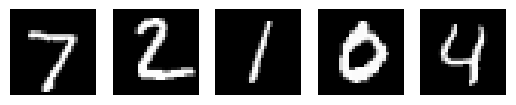

N: 10000
n: 784


In [2]:
## Center the data
X = np.array(data.data.float())/255
mean = X.mean()
print(f"Mean: {mean}")
X = (X - mean)
## Print the first 5 digits in row
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

##
N = X.shape[0]
n = X.shape[1]*X.shape[2]
X = X.reshape(N, -1)
print(f"N: {N}")
print(f"n: {n}")

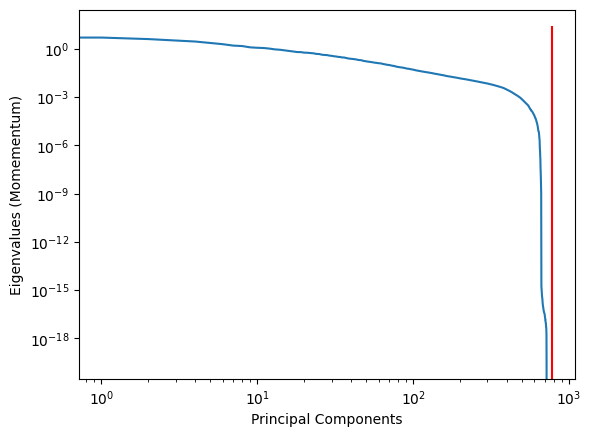

In [3]:
### Finding the principal directions with sklearn (three manners)
# Directly finding the eigen values of the X^TX
M = (X.T @ X)/N
eigenvalues, eigenvectors = np.linalg.eigh(M)

# sort in decreasing order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
#plot all the eigenvalues (x-axis in log scale)
plt.plot(eigenvalues)
plt.xscale('log')
plt.yscale('log')
# The rank of M never exceed n
plt.vlines(n,0, max(eigenvalues), colors="r")
plt.xlabel("Principal Components")
plt.ylabel("Eigenvalues (Momementum)")
plt.show()

In [ ]:

## Second method: Using the singular value decomposition
U, S, V = np.linalg.svd(X, full_matrices=False)
V = V.T
print(f"Are the values the same? {np.allclose(eigenvalues, S**2/N, atol=1e-5)}")
print(f"Computational Error: {np.linalg.vector_norm((S**2)/N - eigenvalues)}")


Are the values the same? True
Computational Error: 9.966553079721052e-06


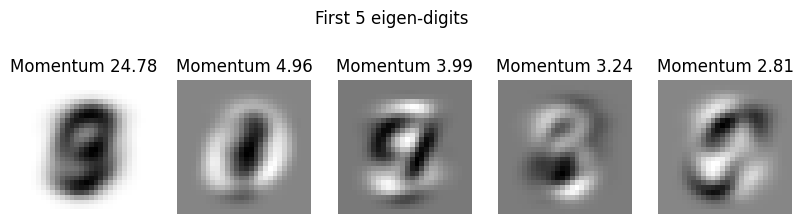

In [ ]:
### Showing the first 5 components
fig, ax = plt.subplots(1, 5, figsize=(10,5))
fig.suptitle('First 5 eigen-digits')
fig.subplots_adjust(top=1.3)
for i in range(5):
    ax[i].imshow(V[:,i].reshape(28, 28), cmap='gray')
    ax[i].set_title(f'Momentum {(S[i]**2)/N:.2f}')
    ax[i].axis('off')
plt.show()

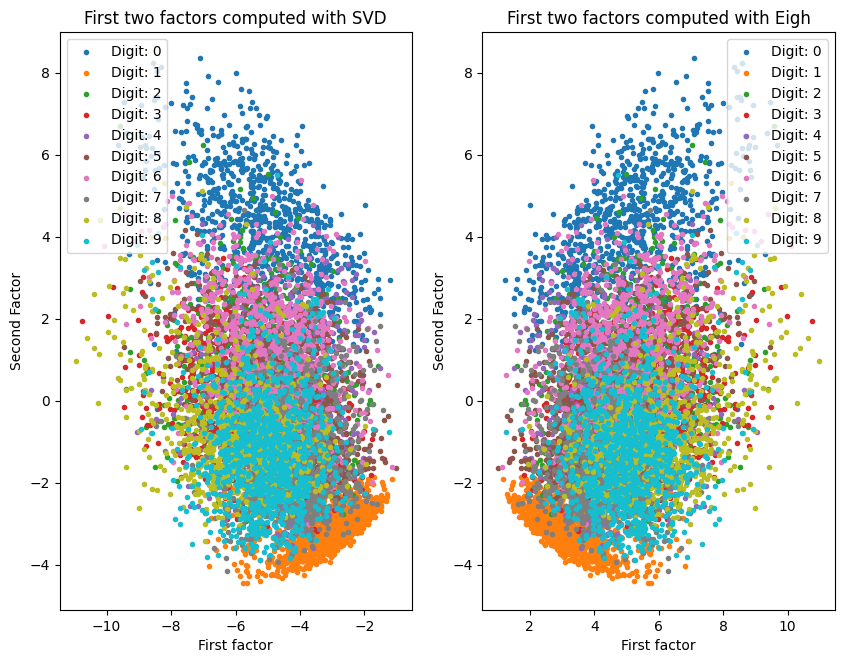

Are they different?


In [ ]:
## Computing the factors, and visualizing few of them

F = X@V
# plot the data grouped by clusters
fig, ax = plt.subplots(1,2,figsize=(10, 7.5))
for i in range(10):
    ax[0].scatter(F[data.targets == i, 0], F[data.targets == i, 1], label=f"Digit: {i}", marker=".")
ax[0].set_title("First two factors computed with SVD")
ax[0].legend()
ax[0].set_xlabel('First factor')
ax[0].set_ylabel('Second Factor')
F_eigh = X@eigenvectors
for i in range(10):
    ax[1].scatter(F_eigh[data.targets == i, 0], F_eigh[data.targets == i, 1], label=f"Digit: {i}", marker=".")
ax[1].set_title("First two factors computed with Eigh")
ax[1].legend()
ax[1].set_xlabel('First factor')
ax[1].set_ylabel('Second Factor')
plt.show()
print("Are they different?")

In [ ]:
## Visualization of the facotors with plotly in three dimensions
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# set the colors form tab10 of matplot lib
colors = plt.cm.tab10(range(10))
# plot differnt digits with a differnt legend
print(F.shape)
df = pd.DataFrame(F[:,:3], columns=['factor1', 'factor2', "factor3"])
df['digit'] = data.targets
df["digit"] = df.digit.astype(str)
df.sort_values(by="digit", inplace=True)
fig = px.scatter_3d(df, x="factor1", y="factor2", z="factor3", color="digit")
fig.update_traces(marker=dict(size=2, opacity=0.8))
# save the html
fig.write_html("mnist_factors.html")
fig.show()


(10000, 784)


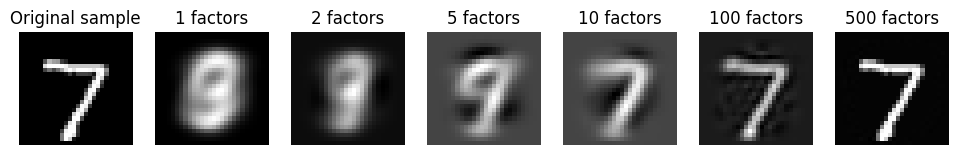

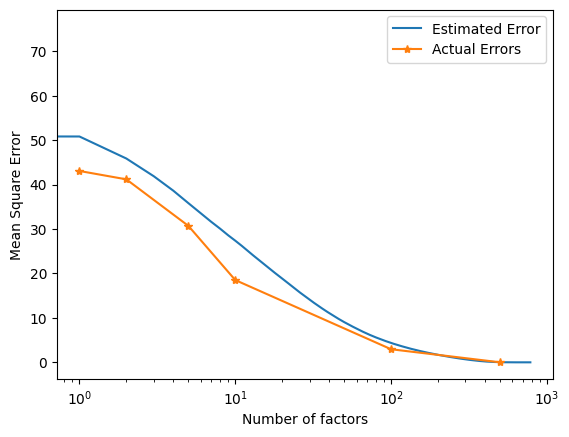

In [ ]:
## Compressing with PCA, representation error

estimated_error = ((S**2)/(N-1))[::-1].cumsum()[::-1]
n_values= [1,2,5,10,100,500]

fig, ax = plt.subplots(1, len(n_values)+1, figsize=(12, 5))
# Draw original sample
ax[0].imshow(X[0].reshape(28, 28), cmap='gray')
ax[0].set_title('Original sample')
ax[0].axis('off')

errors = []
for idx, n_factors in enumerate(n_values,1):
  #Draw compression with nfactors
  X_compressed = F[:,:n_factors]@V[:,:n_factors].T
  errors.append((np.linalg.norm(X[0] - X_compressed[0], axis=-1)**2).mean())
  ax[idx].imshow(X_compressed[0].reshape(28, 28), cmap='gray')
  ax[idx].set_title(f'{n_factors} factors')
  ax[idx].axis('off')
plt.show()
fig, ax = plt.subplots(1)
ax.plot(estimated_error, label="Estimated Error")
ax.plot(n_values, errors, label="Actual Errors", marker="*")
ax.set_xlabel('Number of factors')
ax.set_ylabel('Mean Square Error')
ax.set_xscale('log')
ax.legend()
plt.show()
# Draw the estimated error and the actual value

np.float32(50.796043)